<a href="https://colab.research.google.com/github/MrBenjaminHolmes/Gravitational-Waves/blob/main/GWpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational Wave Open Data Scripts

##Initialization

In [1]:
!pip install -q gwpy==3.0.12

In [2]:
! pip install -q PyCBC==2.4.1 lalsuite==7.25

In [3]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import gwpy
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform, fd_approximants
import matplotlib.pyplot as plt

##Noise Comparison 1.1

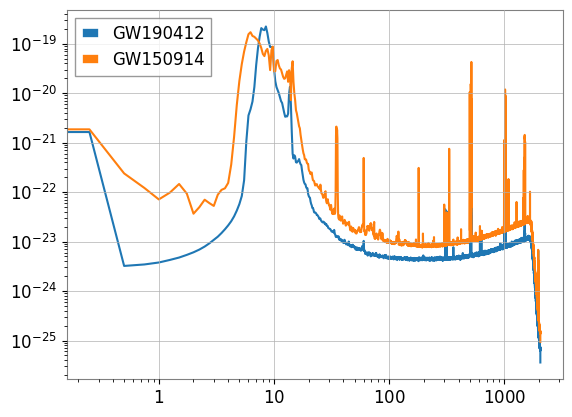

In [4]:
#--GW190412 Data-#
gw19 = event_gps('GW190412')
gw19Data = TimeSeries.fetch_open_data('L1', int(gw19)-512, int(gw19)+512, cache=True)
gw19ASD = gw19Data.asd(fftlength=4, method="median")

#--GW150914 Data-#
gw15 = event_gps('GW150914')
gw15Data = TimeSeries.fetch_open_data('L1', int(gw15)-512, int(gw15)+512, cache=True)
gw15ASD = gw15Data.asd(fftlength=4, method="median")

plt.loglog(gw19ASD, label = 'GW190412')
plt.loglog(gw15ASD,label = 'GW150914')
plt.legend()

plt.show()

##Spectogram 1.2

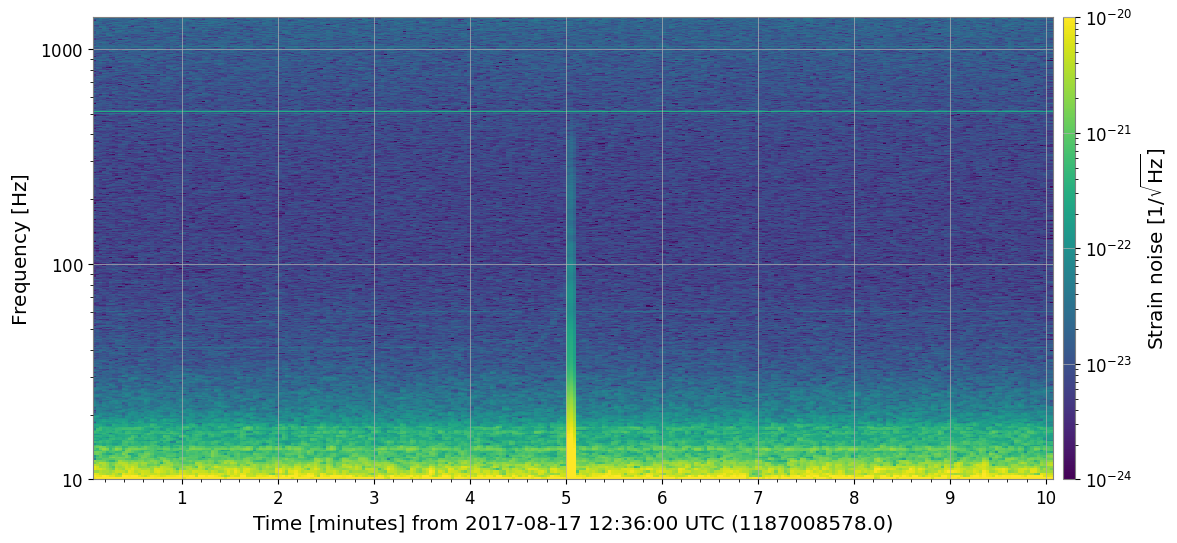

In [5]:
gps = event_gps("GW170817")
ldata = TimeSeries.fetch_open_data("L1", gps - 300, gps + 300, cache=True)
specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (0.5)
plot = specgram.plot();

ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)

##Q-Transform 1.3

Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1186741856 .. 1186741863))
Reading data... [Done]


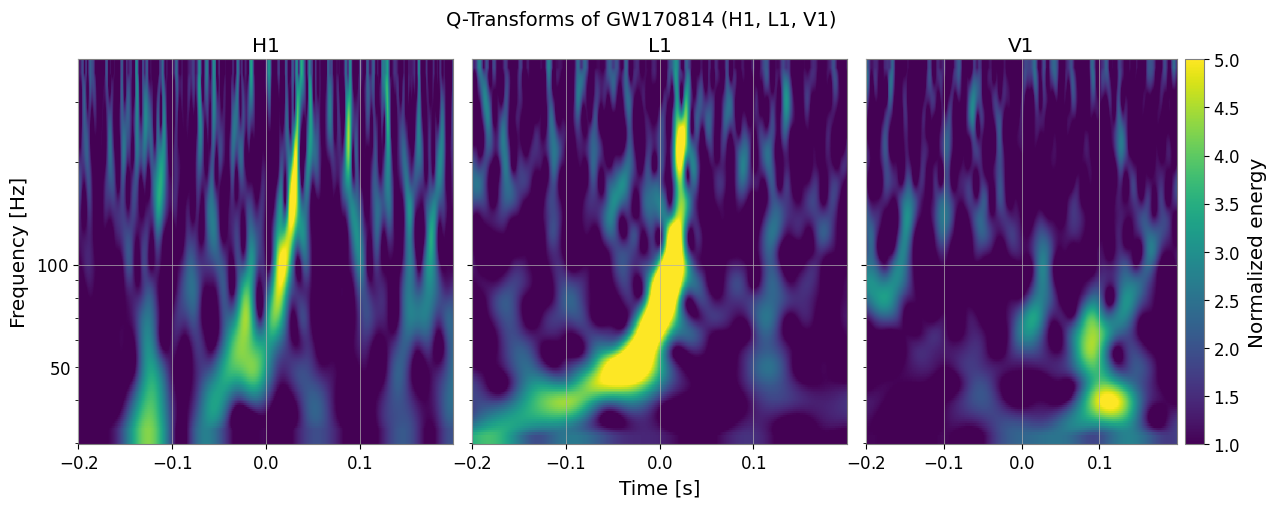

In [6]:
gps = event_gps("GW170814")
segment = (int(gps) - 5, int(gps) + 2)
hData = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
lData = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True)
vData = TimeSeries.fetch_open_data('V1', *segment, verbose=True, cache=True)

hq = hData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))
lq = lData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))
vq = vData.q_transform(frange=(30, 400), qrange=(4, 20), outseg=(gps-0.2, gps+0.2))

hq_plot = hq.abs()**0.5
lq_plot = lq.abs()**0.5
vq_plot = vq.abs()**0.5

#-----------Graphing Data-----------#
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)

xt_h = hq_plot.times.value - gps
xt_l = lq_plot.times.value - gps
xt_v = vq_plot.times.value - gps

im0 = ax[0].pcolormesh(xt_h, hq_plot.frequencies.value, hq_plot.value.T, vmin=1, vmax=5)
im1 = ax[1].pcolormesh(xt_l, lq_plot.frequencies.value, lq_plot.value.T, vmin=1, vmax=5)
im2 = ax[2].pcolormesh(xt_v, vq_plot.frequencies.value, vq_plot.value.T, vmin=1, vmax=5)

# Axis formatting
ax[0].set_title('H1')
ax[1].set_title('L1')
ax[2].set_title('V1')

ax[1].set_xlabel("Time [s]")

for a in ax:
    a.set_yscale('log')

ax[0].set_ylabel('Frequency [Hz]')


cbar = fig.colorbar(im2, ax=ax[2], pad=0.02)
cbar.set_label('Normalized energy')

fig.subplots_adjust(wspace=0.05)
plt.suptitle("Q-Transforms of GW170814 (H1, L1, V1)", fontsize=14)
plt.show()
#---------------------------------------#

##Strain VS Mass 1.4

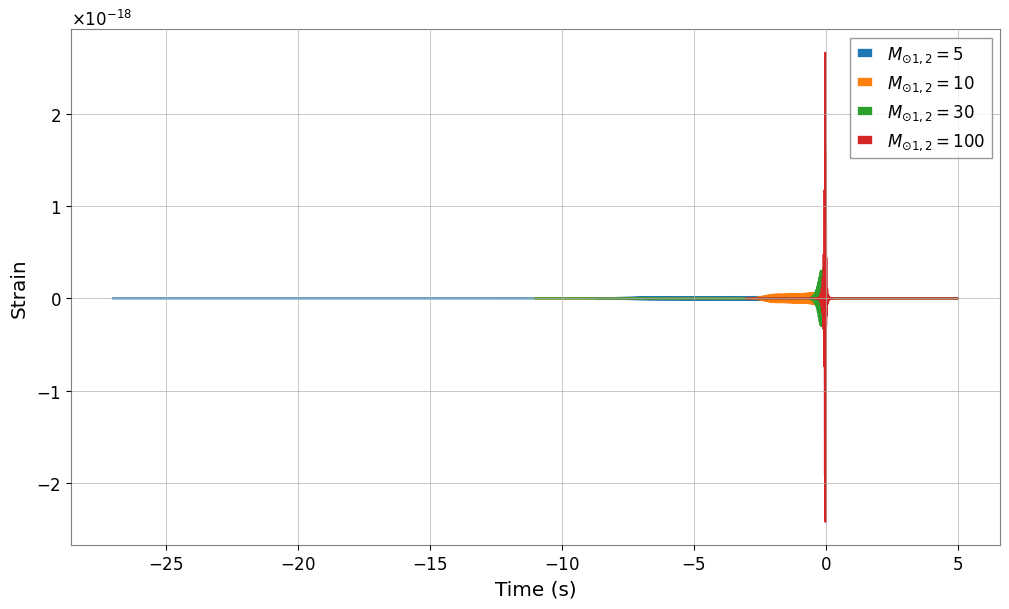

In [7]:
plt.figure(figsize=(10, 6))
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    plt.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

##Waveform Generation 1.5
Generating a waveform for the binary neutron star merger GW170817

|  Data  | Value |
| ------------- | ------------- |
| Mass 1  (☉)|  1.46 |
| Mass 2 (☉)|  1.27 |
| Distance (Mpc) |  40 |


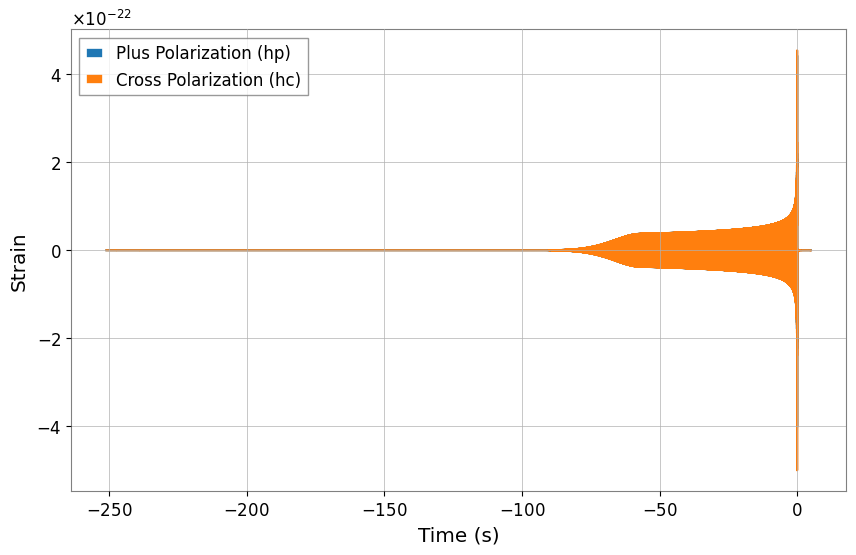

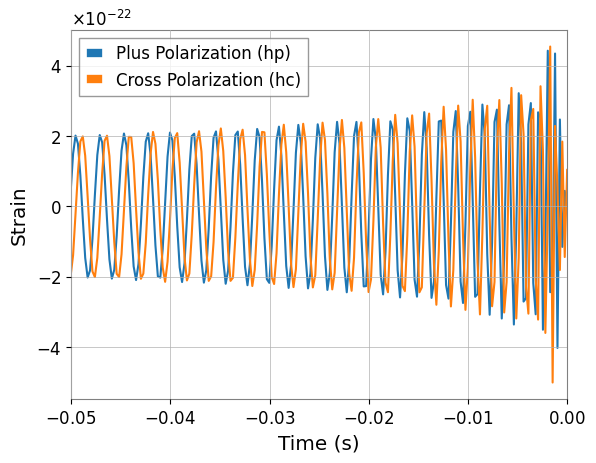

In [21]:
plt.figure(figsize=(10, 6))
hp,hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=1.46,
                         mass2=1.27,
                         delta_t=1.0/4096,
                         f_lower=30,
                        distance = 40
                        )
plt.plot(hp.sample_times, hp, label='Plus Polarization (hp)')
plt.plot(hc.sample_times, hc, label='Cross Polarization (hc)')
plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()

plt.plot(hp.sample_times, hp, label='Plus Polarization (hp)')
plt.plot(hc.sample_times, hc, label='Cross Polarization (hc)')
plt.legend()
plt.grid(True)
plt.xlim(-0.05,0)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.show()